In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:101% !important; }</style>"))
import numpy as np

In [2]:
import csv
FRFN   = "./HLC/muf_os9_frames_info.txt"
FRL    = [] # FRame List
FRLndx = 0  # FRame List index
with open(FRFN, newline='') as fileOpen:
    fileOpenReader = csv.reader(fileOpen, delimiter='\t')
    for line in fileOpenReader:
        if FRLndx > 0 :
            tk=line[0].split()
            record=[]
            record.append('%.6f'%float(tk[0]))
            record.append(int(tk[1]))
            record.append(int(tk[2]))
            record.append(int(tk[3]))
            record.append(int(tk[4]))
            record.append(float(tk[5]))
            record.append(FRLndx-1)            
            FRL.append(record)
        FRLndx=FRLndx+1

In [3]:
"""
# Ygouf 2021 Page 11:
# "File name MUFs Noise Planets Flux Units
# ...
# muf os9 ccd images with planets.fits X X X EMCCD counts"
# So this data has MUFs, Noise, and Planets, and uses EMCCD counts
"""
from astropy.io import fits
fitsFN    = "./HLC/os9_hlc_muf/muf_os9_ccd_images_with_planets.fits"
HDUL      = fits.open(fitsFN)
refcount  = 0
mtgcount  = 0
ptgcount  = 0
startii   = 0
end__ii   = 0
noc       = 0 # next object code
loc       = 0 # next object code
summaryL  = [] # summary List
summaryL.append(startii)
for ii in range (len(HDUL[0].data)):
    #print(HDUL[0].data[ii][0][0], "...", HDUL[0].data[ii][0][len(HDUL[0].data[ii][0])-1])
    noc = FRL[ii][1] * FRL[ii][3] + FRL[ii][4]
    if noc != loc :
        end__ii = ii-1
        if ii> 0 : 
            summaryL.append(end__ii)
            summaryL.append(end__ii-startii+1)
            summaryL.append(loc-FRL[ii][4]+1)
            summaryL.append(    FRL[ii][4]-1)
            summaryL.append(    FRL[ii-1][5])
        startii = ii
        if ii> 0 : summaryL.append(startii)
    if   ( noc == 0 + FRL[ii][4]):
        #print(       ii,FRL[ii][0],"ref",refcount,noc-FRL[ii][4],loc-FRL[ii][4],end__ii,startii)
        refcount=refcount+1
    elif ( noc == -11 + FRL[ii][4] ):
        #print("\t"  ,ii,FRL[ii][0],"mtg",mtgcount,noc-FRL[ii][4],loc-FRL[ii][4],end__ii,startii)
        mtgcount=mtgcount+1
    elif ( noc == 11 + FRL[ii][4] ):
        #print("\t\t",ii,FRL[ii][0],"ptg",ptgcount,noc-FRL[ii][4],loc-FRL[ii][4],end__ii,startii)
        ptgcount=ptgcount+1
        
    loc = FRL[ii][1] * FRL[ii][3] + FRL[ii][4]
summaryL.append(len(HDUL[0].data)-1)
summaryL.append(len(HDUL[0].data)-1-startii+1)
summaryL.append(loc-FRL[ii][4])
summaryL.append(    FRL[ii][4])
summaryL.append(    FRL[ii][5])

In [4]:
summaryRA = np.array(summaryL).astype(int) # summary ARray
summaryT  = np.reshape(summaryRA,(-1,6))   # summary Table

In [5]:
def photCorrPC_FirstOrder ( nobs, nfr, t, g ) :
    """
    Ygouf Page 7 and Nemati Page 8 Eq. 19
    """
    lam_est = -np.log ( 1 - ( nobs / nfr )   *   np.exp ( t / g ) )
    return lam_est
    
def photCorrPC_ThirdOrder ( nobs, nfr, t, g ) : # Nemati (2020) Appendix
    #     print("nfr", nfr, "t", t, "g", g)
    """
    # nobs = number of observed and counted photons.
    #        "The number of _counts_ of an above-threshold photon, that have been summed up."
    # nfr  = number of frames.
    #        "The number of _frames_ across which the number of observations of above-threshold photons have occured."
    # t    = threshold.
    #        "The threshold of electrons that determines whether a pixel is considered to have recorded a _countable_ photon."
    # g    = gain.
    #        "Electro Multiplying Gain = How many electrons are mobilized by one photon, using this version of CCD pixel..."
    #        "Therefore, how many electrons need to be counted to signify that a countable photon has occured."
            # https://www.photometrics.com/learn/imaging-topics/on-chip-multiplication-gain
            # "The level of EM gain can be controlled by either increasing or decreasing the voltage;
            # the gain is exponentially proportional to the voltage. 
            # Multiplying the signal above the read noise of the output amplifier enables ultra-low-light detection at high operation speeds. 
            # EM gain can exceed 1000x."
    """
    #lam_est = -np.log ( 1 - ( nobs / nfr )   *   np.exp ( t / g ) )
    lam_est = photCorrPC_FirstOrder ( nobs, nfr, t, g ) 
    lam_est = lam_est - deltaLam ( lam_est, t, g, nfr, nobs )
    lam_est = lam_est - deltaLam ( lam_est, t, g, nfr, nobs )
    return lam_est
    
def deltaLam ( lam, t, g, nfr, nobs) : # Nemati 2020
    """
    # lam  = AKA "lam_est" in photCorrPC = mean expected rate per pixel per frame
    #        "A value less than one, representing the expected rate that a photon will hit that pixel in that frame inside the frame's exposure time."
    # t    = threshold [measured in electrons] chosen for photon counting
    # g    = EM gain
    # nfr  = number of frames.
    # nobs = number of observed and counted photons.
    """
    ft1 = lam**2            # frequent term #1
    ft2 = 6 + 3 * lam + ft1 # frequent term #2
    ft3 = 2 * g**2 * ft2    # frequent term #3 ; ft3 = 2 * g**2 * ( 6 + 3 * lam + ft1 )
    
    # Epsilon PC = Epsilon Photon Counting = Thresholding Efficiency
    epsThr3 = np.exp( - t / g ) * ( t**2 * ft1 + 2 * g * t * lam * ( 3 + lam ) + ft3 ) / ft3 

    # Epsilon Coincidence Loss = Coincidence Loss (Efficiency)
    epsCL = ( 1 - np.exp ( - lam ) ) / lam
    
    func = lam * nfr * epsThr3 * epsCL - nobs
    
    # dfdlam
    dfdlam_1tN  = np.exp ( - t / g - lam) * nfr # First term numerator
    dfdlam_1tD  = 2 * g**2 * ft2**2             # 1t denominator ; { dfdlam_1tD  = 2 * g**2 * ( 6 + 3 * lam * ft1 )**2 } 
    dfdlam_2ts1 = dfdlam_1tD                 # 2t, 1 summand ; { dfdlam_2ts1 = 2 * g**2 * ( 6 + 3 * lam * ft1 )**2 }
    #dfdlam_2ts2 = t**2 * lam * ( -12 + 3 * lam + 3 * ft1 + lam**3 + 3 * np.exp ( lam ) * (4 + lam) ) # 2t, 2s
    dfdlam_2ts2 = t**2 * lam * ( -12 + 3 * lam + 3 * ft1 + ft1*lam + 3 * np.exp ( lam ) * (4 + lam) ) # 2t, 2s
    #dfdlam_2ts3 = 2 * g * t * ( -18 + 6 * lam + 15 * ft1 + 6 * lam**3 + lam**4 + 6 * np.exp ( lam ) * ( 3 + 2 * lam ) ) # 2t, 3s
    dfdlam_2ts3 = 2 * g * t * ( -18 + 6 * lam + 15 * ft1 + 6 * ft1*lam + ft1**2 + 6 * np.exp ( lam ) * ( 3 + 2 * lam ) ) # 2t, 3s
    dfdlam      = dfdlam_1tN * dfdlam_1tD * ( dfdlam_2ts1 + dfdlam_2ts2 + dfdlam_2ts3 )   
    
    dlam = func / dfdlam
    
#     print("dlam",dlam)
    return dlam

def backgroundcorrection(data_block):
    side = 6 # noise stamp side length
#     h          = len(data_block)
#     w          = len(data_block[0])
    h          = data_block.shape[0]
    w          = data_block.shape[1]
    
    noisestamp = np.zeros((side,side))
    noisestamp = noisestamp+data_block[h-side:h   ,     0:side] # UL stamp
    noisestamp = noisestamp+data_block[h-side:h   ,w-side:w   ] # UR stamp
    noisestamp = noisestamp+data_block[     0:side,w-side:w   ] # LR stamp
    noisestamp = noisestamp+data_block[     0:side,     0:side] # LL stamp
    noisestamp = noisestamp/4
    noisepixel = np.mean(noisestamp)
#     print("noisepixel",noisepixel)
    data_block = data_block-noisepixel
    return data_block

In [6]:
"""
n_thresholdfactor   # Krist 2020 Page 19, "where 𝑛 = threshold factor", 5 is usually good and is what I use."
                    # Nemati 2020 Page 6 / 13 : 
                    # "Typically a threshold of Tau = 5 * Sigma_r is used, 
                    #    but the best strategy is to flesh out Eq. 9, 
                    #    including the leakage rate from E. 10 and determine an optimum."
sigma_readnoise     # Krist 2020 Page 19, "𝜎 = read noise"
                    # FITS Header, "READNOIS=              100.000 / read noise e-/frame."
gain_trg            # Krist 2020 Page 20, "7080 x 5s gain = 6000 (photon counting)".
gain_ref            # Krist 2020 Page 20, "335 x 60s gain = 100 (analog)".
tau_threshold       # "Typically a threshold of Tau = 5 * Sigma_r is used", Nemati 2020 page 6/13    
"""
"""
# TARGET STAR PROCESSING
# BY THE BOOK : 
# SPCAFR = -np.log ( 1 - SPCAFR / ( numfrm * np.exp ( - n_thresholdfactor * sigma_readnoise / gain_trg ) ) )
# SPCAFR        will be called "nobs"          in Nemati equations
# numfrm        will be called "nfr"           in Nemati equations
# tau_threshold will be called "threshold" (t) in Nemati equations
# gain_trg      will be called "gain"      (g) in Nemati equations
# The following steps were performed for each pointing of each
#   noisy target data cube at both -11 degrees and +11 degrees:
# • Apply threshold to each frame of data cube. We chose a threshold factor of 5 
#   (5 times read noise, note that read noise can be found in the FITS header) 
#   in this case. Binary images were obtained in output;
# • Co-add frames in data cube along the temporal dimension;
# • Correct for the coincidence and threshold losses;
# • Background correction is performed by averaging a subset of 36 pixels in the
#   corner of the image;
# • Normalization by the frame exposure time to obtain an image in count/sec.
"""
"""
# REFERENCE STAR PROCESSING
# Krist 2020 Page 19 :
# "Due to coincidence issues, bright stars have fluxes too high for photon counting 
#     (too many counts per shortest possible exposure) and so must be imaged at lower gains (<100),
#     sometimes termed “analog mode”
#     • real flux = counts / gain"
# Krist 2020 Page 21 :
# "The user must process reference star frames as analog mode (gain multiplied) images."
# Ygouf 2021 Page 9:
# "Data cubes for the reference star, 
# as well as all noiseless data cubes do not need to be photon-counted.
# However, two steps need to be performed to preprocess those data cubes:
# • Co-add frames in data cube along the temporal dimension;
# • Normalization by the frame exposure time to obtain an image in count/sec;
# • Dividing by the gain in the case of noisy data for _the_ reference [the] star 
#    (note that the gain can be found in the FITS header)."
"""

n_thresholdfactor = 5
sigma_readnoise   = 100
gain_trg          = 6000
gain_ref          = 100
tau_threshold     = n_thresholdfactor * sigma_readnoise
mtgSPCAFRL        = []
ptgSPCAFRL        = []
refSPCAFRL        = []

for rec in summaryT: # (retain test =>)     rec = summaryT[1]
    strtii   = rec[0]
    end_ii   = rec[1]
    numfrm   = rec[2] # number of frames, equivalent to "nfr" in Nemati equations
    star     = rec[3] # "0" is ref, "-11" is mtg, "11" is ptg
    visit    = rec[4] # equivalent to "Target Pointing" in Ygouf Table 1
    exptim   = rec[5]
    SPDC     = HDUL[0].data [ strtii : end_ii + 1 ] # Single Pointing Data Cube
    if star != 0:
        
        # Ygouf Page 9: "Apply threshold to each frame of data cube. We chose a threshold factor of 5 
        # (5 times read noise, note that read noise can be found in the FITS header) in this case.
        # Binary images were obtained in output;"
        SPDC [ SPDC < tau_threshold ] = 0
        SPDC [ SPDC > tau_threshold ] = 1
        
        # Ygouf Page 9: "Correct for the coincidence and threshold losses;"
        SPDC   = photCorrPC_FirstOrder ( SPDC, numfrm, tau_threshold, gain_trg )
        
        # Ygouf Page 9: "Co-add frames in data cube along the temporal dimension;"
        SPCAFR = np.sum ( SPDC, axis = 0 ) # Single Pointing Co-Added Frame
        
        # Ygouf Page 9: "Background correction is performed by averaging a subset of 36 pixels in the corner of the image;"
        SPCAFR = backgroundcorrection ( SPCAFR )
        
        # Ygouf Page 9: "Normalization by the frame exposure time to obtain an image in count/sec."
        SPCAFR = SPCAFR / exptim
        
        if   star == -11:
            
            mtgSPCAFRL.append(SPCAFR)
            
        elif star == 11:

            ptgSPCAFRL.append(SPCAFR)
            
    elif   star == 0:

        # Ygouf Page 9: "Co-add frames in data cube along the temporal dimension;"
        SPCAFR = np.sum ( SPDC, axis = 0 )
        
        # Ygouf Page 9: "Normalization by the frame exposure time to obtain an image in count/sec;"
        SPCAFR = SPCAFR / exptim
        
        # Ygouf Page 9: "Dividing by the gain in the case of noisy data for reference the star"
        SPCAFR = SPCAFR / gain_ref
                
        refSPCAFRL.append(SPCAFR)

# mtg, ptg and ref have now been 1stnormalized to units of COUNTS PER SECOND
# mtg, ptg and ref still need to be 2ndnormalized to CONTRAST UNITS

HDUL.close()

In [7]:
mtgSPCAFRRA = np.array(mtgSPCAFRL)
ptgSPCAFRRA = np.array(ptgSPCAFRL)
refSPCAFRRA = np.array(refSPCAFRL)

In [8]:
"""
FUDGE FACTOR FOR REFERENCE GOING INTO PHOTONS / SECOND / PIXEL
"""

FUDGE1_REF  = 60

refSPCAFRRA = refSPCAFRRA / FUDGE1_REF

In [9]:
# Get a sample frame of each kind to be plotted after parallel processing
data_ref_for_plot_1 = refSPCAFRRA[0]
data_mtg_for_plot_1 = mtgSPCAFRRA[0]
data_ptg_for_plot_1 = ptgSPCAFRRA[0]    

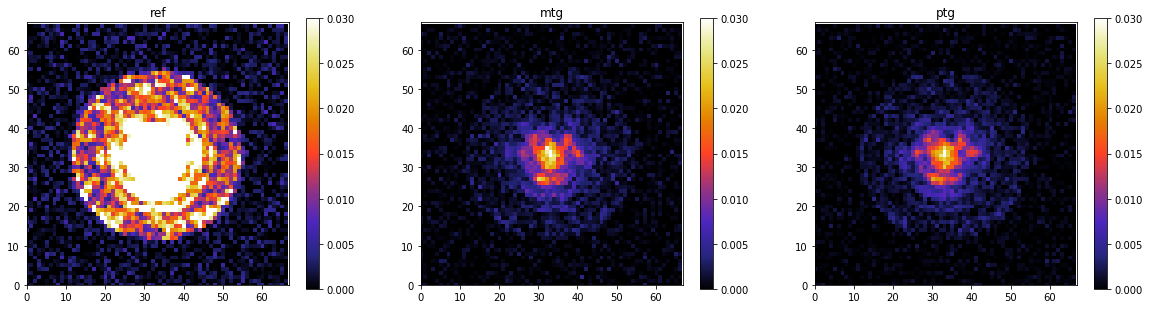

In [10]:
# Ygouf Page 11 Figure 5 Bottom Row, MUF & Noisy
# in units of Photons / second / pixel
import matplotlib.pyplot as plt
plt.figure (figsize=[20,5])
vmaxval = 0.03

plt.subplot (131)
plt.title   ("ref")
plt.imshow  (data_ref_for_plot_1,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_ref_for_plot_1[0]) ] ) 
plt.ylim    ( [ 0, len(data_ref_for_plot_1   ) ] )
plt.colorbar()

plt.subplot (132)
plt.title   ("mtg")
plt.imshow  (data_mtg_for_plot_1,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_mtg_for_plot_1[0]) ] ) 
plt.ylim    ( [ 0, len(data_mtg_for_plot_1   ) ] )
plt.colorbar()

plt.subplot (133)
plt.title   ("ptg")
plt.imshow  (data_ptg_for_plot_1,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_ptg_for_plot_1[0]) ] ) 
plt.ylim    ( [ 0, len(data_ptg_for_plot_1   ) ] )
plt.colorbar()

In [11]:
# SECOND NORMALIZATION; NORMALIZE TO CONTRAST UNITS
"""
# Ygouf Page 10 
# "Then we extract the maximum value from the entire datacube
# (5.5*10^-3 and 9.6*10^-3
# for the noiseless and noisy data respectively)."
# maxflux = 6.307266e-04 # value I got 
"""
maxflux = 9.6e-3 
refSPCAFRRA = refSPCAFRRA / maxflux
mtgSPCAFRRA = mtgSPCAFRRA / maxflux
ptgSPCAFRRA = ptgSPCAFRRA / maxflux

# These are not yet "primary-flux-normalized datacubes"

# NOW DIVIDE BY FLUX OF THE SPECIFIC STAR -- TO GET NORMALIZATION IN CONTRAST UNITS
"""
# Krist Page 25
# "Wavelengths and corresponding flux rates for each star are given in os9_fluxes.txt"
# "                ref_star         target_star
#    lambda        Zeta Pup           47 UMa
#      um         photons/sec       photons/sec
#    ...
#   0.57500000   1.19088520e+08   10383809.09954967"
# muf_os9_ccd_images_with_planets.fits header:
# "LAMBDA  =             0.575000 / bandpass central wavelength in microns "
"""
rfcw = 1.19088520e+08    # ref flux at central wavelength
tfcw = 10383809.09954967 # trg flux at central wavelength

refSPCAFRRA = refSPCAFRRA / rfcw
mtgSPCAFRRA = mtgSPCAFRRA / tfcw
ptgSPCAFRRA = ptgSPCAFRRA / tfcw

# These are now supposed to have "normalization in contrast units." (Ygouf Page 10)

In [12]:
"""
FUDGE FACTOR FOR TARGET GOING INTO UNITS OF CONTRAST
"""

FUDGE2_TRG = 5

mtgSPCAFRRA = mtgSPCAFRRA / FUDGE2_TRG
ptgSPCAFRRA = ptgSPCAFRRA / FUDGE2_TRG

In [13]:
# Get a sample frame of each kind to be plotted after parallel processing
data_ref_for_plot_2 = refSPCAFRRA[0]
data_mtg_for_plot_2 = mtgSPCAFRRA[0]
data_ptg_for_plot_2 = ptgSPCAFRRA[0]        

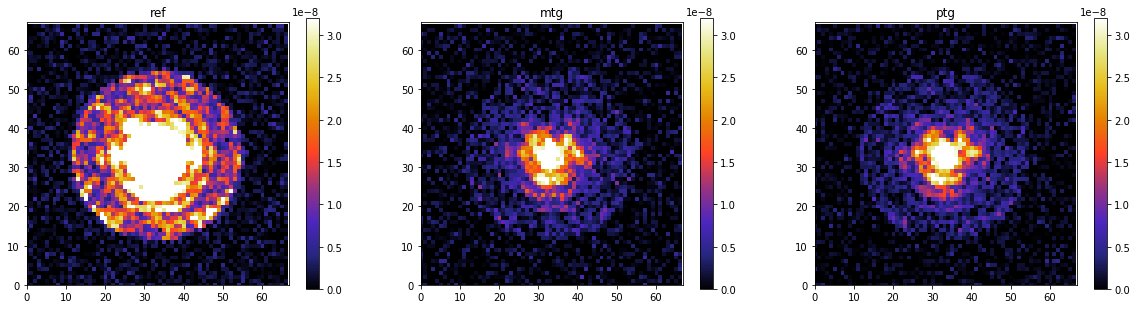

In [14]:
# Ygouf Page 12 Figure 6, [Bottom Right] MUF, Noisy. (ref not included)
# in units of contrast
plt.figure (figsize=[20,5])
vmaxval = 1e-8
toptick = 3.2

plt.subplot (131)
plt.title   ("ref")
plt.imshow  (data_ref_for_plot_2,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_ref_for_plot_2[0]) ] ) 
plt.ylim    ( [ 0, len(data_ref_for_plot_2   ) ] )
plt.colorbar()
plt.clim    (0,toptick*vmaxval)

plt.subplot (132)
plt.title   ("mtg")
plt.imshow  (data_mtg_for_plot_2,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_mtg_for_plot_2[0]) ] ) 
plt.ylim    ( [ 0, len(data_mtg_for_plot_2   ) ] )
plt.colorbar()
plt.clim    (0,toptick*vmaxval)

plt.subplot (133)
plt.title   ("ptg")
plt.imshow  (data_ptg_for_plot_2,cmap = "CMRmap",vmax = vmaxval,vmin = 0)
plt.xlim    ( [ 0, len(data_ptg_for_plot_2[0]) ] ) 
plt.ylim    ( [ 0, len(data_ptg_for_plot_2   ) ] )
plt.colorbar()
plt.clim    (0,toptick*vmaxval)